# Recency, Frequency, Monetary analysis

In [1]:
%matplotlib inline
import kaggle
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

## Load dataset

In [2]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('carrie1/ecommerce-data', path='data', unzip=True)

In [3]:
orders_df = pd.read_csv("data/data.csv", encoding = "ISO-8859-1")
orders_df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID         Country  
0        12/1/2010 8:26       2.55     17850.0  United Kingdom  
1        12/1/2010 8:26       3.39     17850.0  United Kingdom  
2        12/1/2010 8:26       2.75     17850.0  United Kingdom  
3        12/1/2010 8:26       3.39     17850.0  United Kingdom  
4        12/1/2010 8:26       3.39     17850.0  United Kingdom  
...                 ...        ...         ...             ...  
541904  12/9/2011 12:50       0.85     12680.0          France  
541905  12/9/2011 12:50       2.10     12680.0          France  
541906  12/9/2011 12:50       4.15     12680.0          France  
541907  12/9/2011 12:50       4.15     12680.0          France  
541908  12/9/2011 12:50       4.95     12680.0          France  

[541909 rows x 8 columns]

## Data preprocessing

In [4]:
orders_df.dropna()

orders_df['InvoiceDate'] = pd.to_datetime(orders_df['InvoiceDate'])
orders_df['TotalPrice'] = orders_df['Quantity'] * orders_df['UnitPrice']

dataset_last_day = orders_df['InvoiceDate'].max() + timedelta(days=1)

process_df = orders_df.groupby(by=['CustomerID'], as_index=False).agg({
    'InvoiceDate': lambda x: (dataset_last_day - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'})

In [5]:
rfm_input_df = pd.DataFrame(data={
    'CustomerId': process_df['CustomerID'],
    'Recency': process_df['InvoiceDate'],
    'Frequency': process_df['InvoiceNo'],
    'MonetaryValue': process_df['TotalPrice']})

rfm_input_df

CustomerId  Recency  Frequency  MonetaryValue
0        12346.0      326          2           0.00
1        12347.0        2        182        4310.00
2        12348.0       75         31        1797.24
3        12349.0       19         73        1757.55
4        12350.0      310         17         334.40
...          ...      ...        ...            ...
4367     18280.0      278         10         180.60
4368     18281.0      181          7          80.82
4369     18282.0        8         13         176.60
4370     18283.0        4        756        2094.88
4371     18287.0       43         70        1837.28

[4372 rows x 4 columns]

## RFM analysis

### RFM distributions

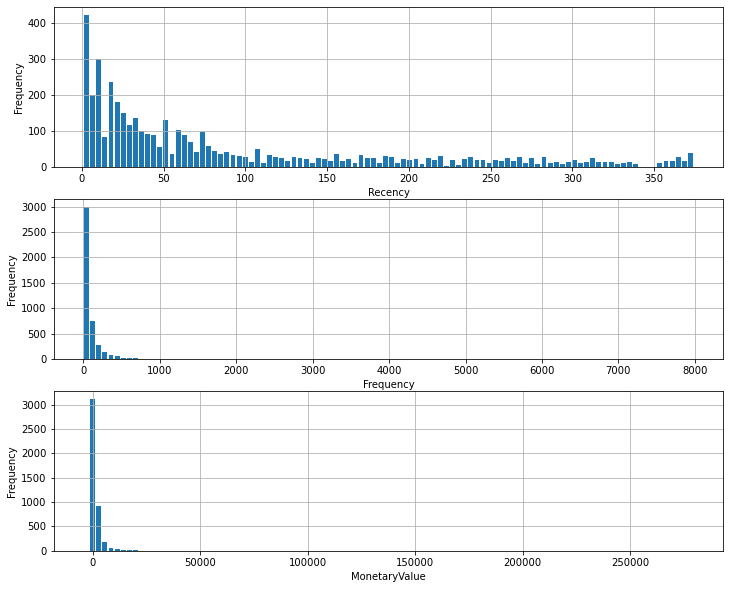

In [6]:
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1)
rfm_input_df['Recency'].plot.hist(grid=True, bins=100, rwidth=0.8)
plt.xlabel('Recency')

plt.subplot(3, 1, 2)
rfm_input_df['Frequency'].plot.hist(grid=True, bins=100, rwidth=0.8)
plt.xlabel('Frequency')

plt.subplot(3, 1, 3)
rfm_input_df['MonetaryValue'].plot.hist(grid=True, bins=100, rwidth=0.8)
plt.xlabel('MonetaryValue')

plt.show()

### Calculate R,F,M groups

In [7]:
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

r_groups = pd.qcut(rfm_input_df['Recency'], q=5, labels=r_labels)
f_groups = pd.qcut(rfm_input_df['Frequency'], q=5, labels=f_labels)
m_groups = pd.qcut(rfm_input_df['MonetaryValue'], q=5, labels=m_labels)

rfm_output_df = rfm_input_df.assign(
    R = r_groups.values,
    F = f_groups.values,
    M = m_groups.values)

rfm_output_df

CustomerId  Recency  Frequency  MonetaryValue  R  F  M
0        12346.0      326          2           0.00  1  1  1
1        12347.0        2        182        4310.00  5  5  5
2        12348.0       75         31        1797.24  2  3  4
3        12349.0       19         73        1757.55  4  4  4
4        12350.0      310         17         334.40  1  2  2
...          ...      ...        ...            ... .. .. ..
4367     18280.0      278         10         180.60  1  1  1
4368     18281.0      181          7          80.82  1  1  1
4369     18282.0        8         13         176.60  5  1  1
4370     18283.0        4        756        2094.88  5  5  5
4371     18287.0       43         70        1837.28  3  4  4

[4372 rows x 7 columns]

### Segmentation

| Segment            | Description                                                | R     | F     | M     |
| ------------------ | ---------------------------------------------------------- | ----- | ----- | ----- |
| Champions          | Bought recently, buy often and spend the most              | > 3   | > 3   | > 3   |
| Loyal Customers    | Spend good money. Responsive to promotions                 | 2 - 4 | 3 - 4 | > 3   |
| Potential Loyalist | Recent customers, spent good amount, bought more than once | > 2   | < 3   | < 3   |
| New Customers      | Bought more recently, but not often                        | > 3   | < 2   | < 2   |
| Promising          | Recent shoppers, but haven’t spent much                    | 3 - 4 | < 2   | < 2   |
| Need Attention     | Above average recency, frequency & monetary values         | 3 - 4 | 3 - 4 | 3 - 4 |
| About To Sleep     | Below average recency, frequency & monetary values         | 2 - 3 | < 3   | < 3   |
| At Risk            | Spent big money, purchased often but long time ago         | < 3   | > 1   | > 1   |
| Can’t Lose Them    | Made big purchases and often, but long time ago            | < 2   | > 3   | > 3   |
| Hibernating        | Low spenders, low frequency, purchased long time ago       | 2 - 3 | 2 - 3 | 2 - 3 |
| Lost               | Lowest recency, frequency & monetary scores                | < 2   | < 2   | < 2   |

In [8]:
def getSegment(user):
    r = user['R']
    f = user['F']
    m = user['M']
    if (r > 3 and f > 3 and m > 3):
        return 'Champions'
    if (r > 1 and r < 5 and f > 2 and f < 5 and m > 3):
        return 'Loyal Customers'
    if (r > 2 and f < 3 and m < 3):
        return 'Potential Loyalist'
    if (r > 3 and f < 2 and m < 2):
        return 'New Customers'
    if (r > 2 and r < 5 and f < 2 and m < 2):
        return 'Promising'
    if (r > 2 and r < 5 and f > 2 and f < 5 and  m > 2 and m < 5):
        return 'Need Attention'
    if (r > 1 and r < 4 and f < 3 and m < 3):
        return 'About To Sleep'
    if (r < 3 and f > 1 and m > 1):
        return 'At Risk'
    if (r < 2 and f > 3 and m > 3):
        return 'Cannot Lose Them'
    if (r > 1 and r < 4 and f > 1 and f < 4 and m > 1 and m < 4):
        return 'Hibernating'
    if ( r < 2 and f < 2 and m < 2):
        return 'Lost'
    return 'Others'


rfm_output_df['RFM_Segment'] = rfm_output_df.apply(getSegment, axis=1)
rfm_output_df

CustomerId  Recency  Frequency  MonetaryValue  R  F  M  \
0        12346.0      326          2           0.00  1  1  1   
1        12347.0        2        182        4310.00  5  5  5   
2        12348.0       75         31        1797.24  2  3  4   
3        12349.0       19         73        1757.55  4  4  4   
4        12350.0      310         17         334.40  1  2  2   
...          ...      ...        ...            ... .. .. ..   
4367     18280.0      278         10         180.60  1  1  1   
4368     18281.0      181          7          80.82  1  1  1   
4369     18282.0        8         13         176.60  5  1  1   
4370     18283.0        4        756        2094.88  5  5  5   
4371     18287.0       43         70        1837.28  3  4  4   

             RFM_Segment  
0                   Lost  
1              Champions  
2        Loyal Customers  
3              Champions  
4                At Risk  
...                  ...  
4367                Lost  
4368                Lost  
4369  Potential Loyalist  
4370           Champions  
4371     Loyal Customers  

[4372 rows x 8 columns]

In [9]:
rfm_segments_agg = rfm_output_df.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

rfm_segments_agg

Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Segment                                             
About To Sleep       121.4      13.4         207.3   307
At Risk              192.7      56.8         891.9   723
Champions             12.1     260.7        5840.8   946
Hibernating           48.4      33.3         489.5    65
Lost                 281.8       6.6         110.7   287
Loyal Customers       70.6      70.0        1776.7   383
Need Attention        36.3      58.4         677.6   266
Others                85.9      69.4        1151.2   886
Potential Loyalist    34.5      14.2         239.5   509